<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost/blob/main/Predict_Profitability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.3 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=3f2e1437ae0ef95a9999c8289cfdd9cfcc0cb120ab0ff4f62b8b63300937a605
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=cf22e73845c5859eee1c407b57808cd9e2840dfc906a1f33d57497dc0a63d554
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [6]:
!gdown https://drive.google.com/uc?id=1XmSpgMiQmDZdHlkWT5TfCUUtAbC8BXkP

Downloading...
From: https://drive.google.com/uc?id=1XmSpgMiQmDZdHlkWT5TfCUUtAbC8BXkP
To: /content/profit.zip
100% 23.3k/23.3k [00:00<00:00, 49.1MB/s]


In [7]:
!unzip /content/profit.zip

Archive:  /content/profit.zip
  inflating: 1000_Companies.csv      


In [8]:
df = pd.read_csv('1000_Companies.csv')
df

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


In [9]:
df['State'].value_counts()

California    344
New York      334
Florida       322
Name: State, dtype: int64

#Cleaning Dataset

,missing_value,%
R&D Spend,0,0.0
Administration,0,0.0
Marketing Spend,0,0.0
State,0,0.0
Profit,0,0.0


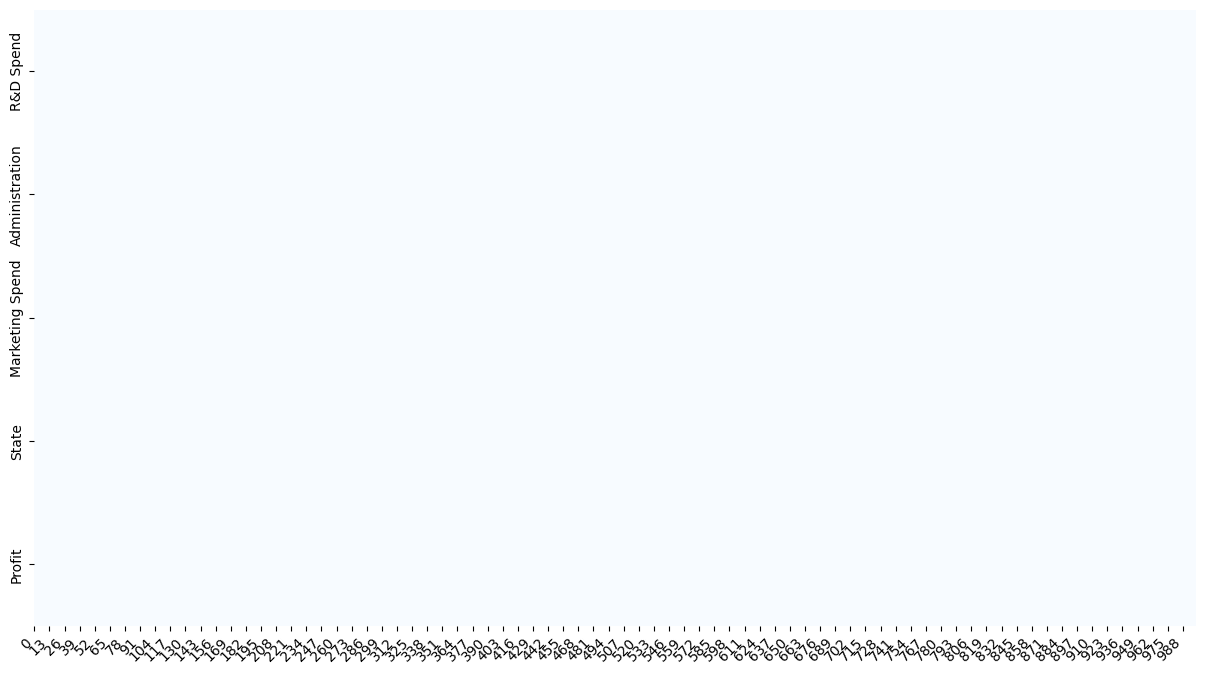

In [10]:
plot_missing_value(df, return_df=True)

#Dataset Splitting

In [11]:
X = df.drop(columns=['Profit'])
y = df['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 4), (200, 4), (800,), (200,))

#Training

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.drop(columns='State').columns),
    ('categoric', cat_pipe(), ['State'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8458637582367365, 'algo__gamma': 10, 'algo__learning_rate': 0.852139338138361, 'algo__max_depth': 9, 'algo__n_estimators': 128, 'algo__reg_alpha': 1.6172900811143165, 'algo__reg_lambda': 0.001987021538542862, 'algo__subsample': 0.7934434683002587}
0.9999999987319188 0.9898538718678411 0.9804206184830275


#Feature Importance

,feature,importance,stdev
0,R&D Spend,1.695198,0.069668
1,Administration,0.167825,0.023224
2,Marketing Spend,0.006817,0.000813
3,State,0.000052,0.000009


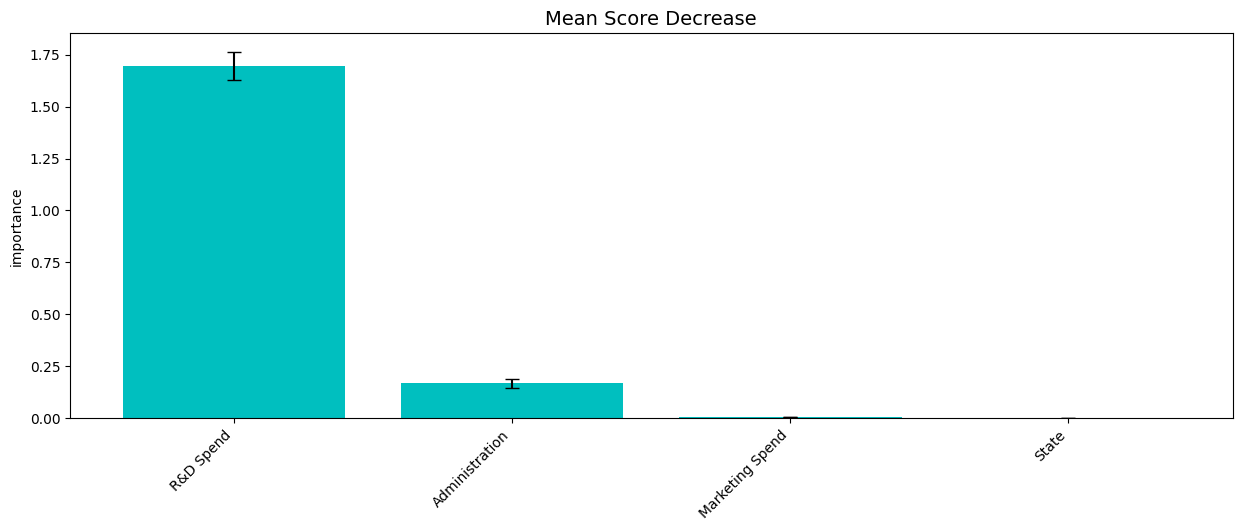

In [16]:
mean_score_decrease(X_train, y_train, model, plot=True, topk=50)

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['R&D Spend', 'Administration'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8951446200396331, 'algo__gamma': 9, 'algo__learning_rate': 0.8056449590587103, 'algo__max_depth': 1, 'algo__n_estimators': 145, 'algo__reg_alpha': 7.3556198508533175, 'algo__reg_lambda': 7.1528630222165415, 'algo__subsample': 0.7265047277336801}
0.9953521731199912 0.9850020427104559 0.9757021850718071
